# LSTM

### Obsah<a class='anchor' id='top'></a>
* [Globálne parametre](#1)
* [Načítanie dát](#2)
* [Rozdelenie dát na testovaciu a trénovaciu sadu](#3)
* [Vytvorenie sekvencií](#4)

In [584]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 
import json
import warnings
from joblib import load
warnings.filterwarnings("ignore")

### Globálne parametre<a class='anchor' id='1'></a>

In [585]:
# Globálne konfiguračné premenné

# Cesty k súborom    
X_PATH = 'X_scaled.npy'
Y_PATH = 'y_labels.npy'
SCALER_PATH = 'scaler.joblib'
FEATURES_PATH = 'final_selected_features.json'  
UC_MAP_PATH = 'uc_map.json'
CLASS_WEIGHT_PATH = 'class_weights.txt'

# Názov stĺpca s cieľovou premennou
LABEL_COLUMN = 'current_uc'       

# Parametre pre rozdelenie dát
TEST_SIZE = 0.2                   
SEED = 42                         

# Parametre pre trénovanie modelu
EPOCHS = 100                       
BATCH_SIZE = 128                   
EARLY_STOP_PATIENCE = 10           
OPTIMIZER = 'adam'                

# Parametre pre LSTM model
SEQUENCE_LENGTH = 60              
LSTM_UNITS = 128                  
DROPOUT_RATE = 0.2                

# Ďalšie parametre
VERBOSE = 1                       

### Načítanie predspracovaných dát <a class='anchor' id='2'></a>

In [586]:
with open(FEATURES_PATH, 'r') as f:
    selected_features = json.load(f)

In [587]:
X_scaled = np.load(X_PATH)
y = np.load(Y_PATH)
scaler = load(SCALER_PATH)

with open(UC_MAP_PATH, "r") as f:
    uc_map = json.load(f)

reverse_uc_map = {v: k for k, v in uc_map.items()}
reverse_uc_map

{1: 'uc1', 2: 'uc2', 3: 'uc3', 4: 'uc4', 5: 'uc5', 6: 'uc6'}

In [588]:
class_weight_dict = {}
with open(CLASS_WEIGHT_PATH, "r") as f:
    for line in f:
        k, v = line.strip().split(":")
        class_weight_dict[int(k)] = float(v)

### Rozdelenie dát na trénovaciu a testovaciu množinu <a class='anchor' id='3'></a>

Sliding window funkcia:

In [589]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

#### Vytvorenie sekvencií <a class='anchor' id='4'></a>

In [590]:
# Najprv vytvor sliding windows z celého datasetu
X_seq, y_seq = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

# Posunieme y o 1, pretože UC sú číslované od 1
y_seq = y_seq - 1

# Potom split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=TEST_SIZE, random_state=SEED, stratify=y_seq
)
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [591]:
print(f"✅ X_train: {X_train.shape}, y_train: {y_train_cat.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test_cat.shape}")

✅ X_train: (35000, 60, 7), y_train: (35000, 6)
✅ X_test: (8750, 60, 7), y_test: (8750, 6)


In [592]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


In [593]:
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])

In [594]:
early_stop = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, restore_best_weights=True)

In [595]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4475 - loss: 1.4358 - val_accuracy: 0.5747 - val_loss: 1.1167
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5800 - loss: 1.0889 - val_accuracy: 0.6238 - val_loss: 0.9697
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6250 - loss: 0.9728 - val_accuracy: 0.6499 - val_loss: 0.9250
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6419 - loss: 0.9092 - val_accuracy: 0.6630 - val_loss: 0.8229
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6548 - loss: 0.9236 - val_accuracy: 0.6622 - val_loss: 0.8476
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6678 - loss: 0.8690 - val_accuracy: 0.6906 - val_loss: 0.8129
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6778 - loss: 0.8438 - val_accuracy: 0.7160 - val_loss: 0.7112
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7087 - loss: 0.7677 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


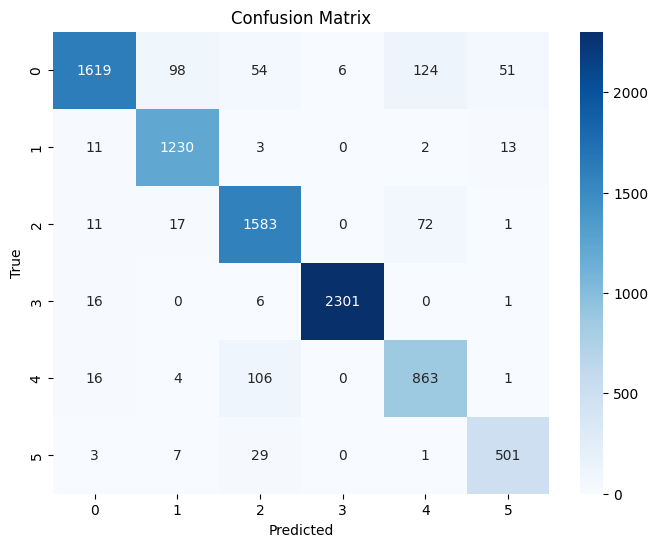

              precision    recall  f1-score   support

           0      0.966     0.829     0.893      1952
           1      0.907     0.977     0.941      1259
           2      0.889     0.940     0.914      1684
           3      0.997     0.990     0.994      2324
           4      0.813     0.872     0.841       990
           5      0.882     0.926     0.904       541

    accuracy                          0.925      8750
   macro avg      0.909     0.922     0.914      8750
weighted avg      0.928     0.925     0.925      8750



In [596]:
# Predikcia
from sklearn.metrics import classification_report, confusion_matrix


y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))

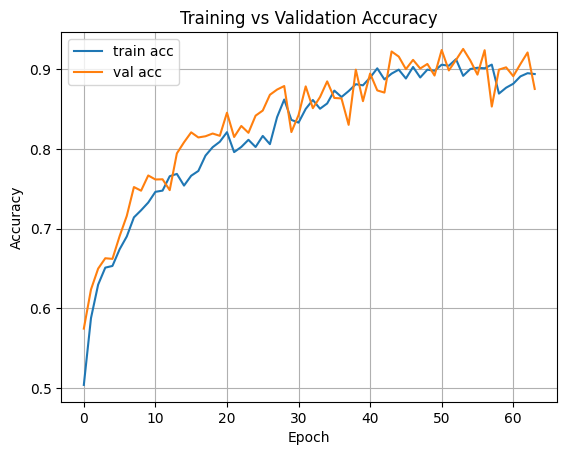

In [597]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [598]:
def build_improved_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.3):
    """
    Vylepšený LSTM model:
    - 2 LSTM vrstvy (druhá menšia)
    - Dropout po každej vrstve
    - Hustá (dense) vrstva pred výstupom
    """
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 4))
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate / 2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [599]:
model2 = build_improved_lstm_model((SEQUENCE_LENGTH, X_train.shape[2]), num_classes, lstm_units=128, dropout_rate=0.1)

In [600]:
history = model2.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.3942 - loss: 1.5130 - val_accuracy: 0.5736 - val_loss: 1.1029
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.5643 - loss: 1.1170 - val_accuracy: 0.6181 - val_loss: 0.9686
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.6066 - loss: 1.0017 - val_accuracy: 0.6515 - val_loss: 0.9072
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.6406 - loss: 0.9179 - val_accuracy: 0.6630 - val_loss: 0.8764
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.6602 - loss: 0.8821 - val_accuracy: 0.7159 - val_loss: 0.7218
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.6970 - loss: 0.7782 - val_accuracy: 0.7043 - val_loss: 0.7383
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - accuracy: 0.7012 - loss: 0.7533 - val_accuracy: 0.7121 - val_loss: 0.7145
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.6998 - loss: 0

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


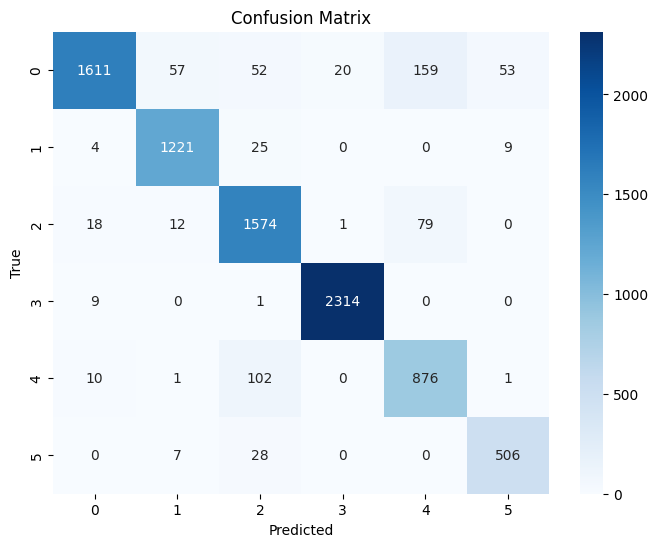

              precision    recall  f1-score   support

           0      0.975     0.825     0.894      1952
           1      0.941     0.970     0.955      1259
           2      0.883     0.935     0.908      1684
           3      0.991     0.996     0.993      2324
           4      0.786     0.885     0.833       990
           5      0.889     0.935     0.912       541

    accuracy                          0.926      8750
   macro avg      0.911     0.924     0.916      8750
weighted avg      0.930     0.926     0.926      8750



In [601]:
y_pred = model2.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))

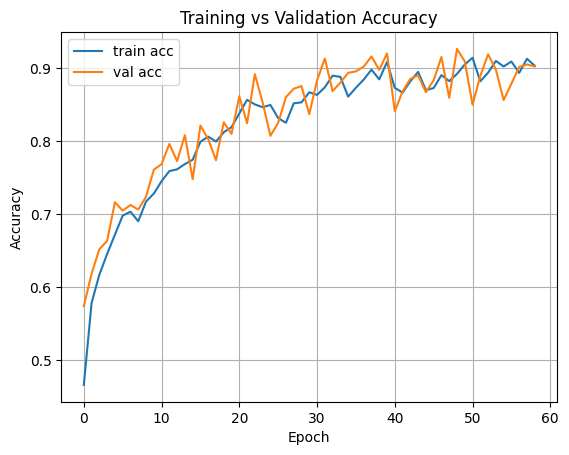

In [602]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.4898 - loss: 1.3286 - val_accuracy: 0.5633 - val_loss: 1.0909
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.6182 - loss: 0.9565 - val_accuracy: 0.6650 - val_loss: 0.8206
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.6635 - loss: 0.8268 - val_accuracy: 0.7079 - val_loss: 0.7342
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7047 - loss: 0.7286 - val_accuracy: 0.7165 - val_loss: 0.6587
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.7194 - loss: 0.6789 - val_accuracy: 0.7549 - val_loss: 0.6342
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.7384 - loss: 0.6459 - val_accuracy: 0.7225 - val_loss: 0.6568
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7482 - loss: 0.6138 - val_accuracy: 0.7865 - val_loss: 0.5056
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.7676 - loss: 0

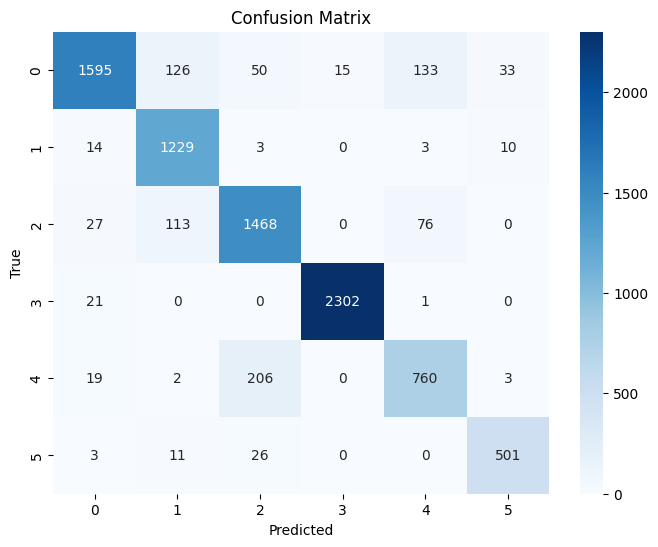

              precision    recall  f1-score   support

           0      0.950     0.817     0.879      1952
           1      0.830     0.976     0.897      1259
           2      0.837     0.872     0.854      1684
           3      0.994     0.991     0.992      2324
           4      0.781     0.768     0.774       990
           5      0.916     0.926     0.921       541

    accuracy                          0.898      8750
   macro avg      0.885     0.892     0.886      8750
weighted avg      0.901     0.898     0.898      8750



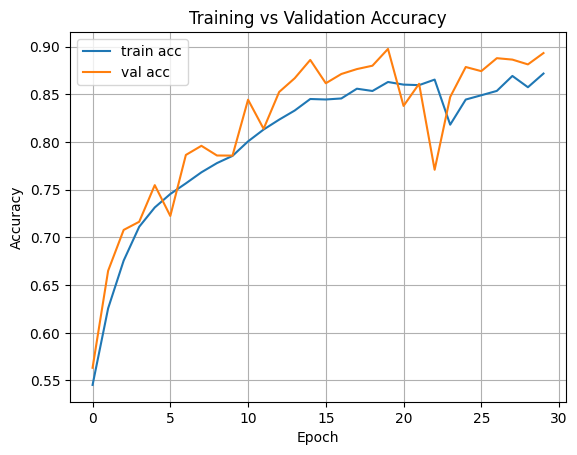

In [603]:
from tensorflow.keras.layers import BatchNormalization

def build_batchnorm_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate / 2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model3 = build_batchnorm_lstm_model((SEQUENCE_LENGTH, X_train.shape[2]), num_classes, lstm_units=128, dropout_rate=0.1)
history = model3.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)
y_pred = model3.predict(X_test).argmax(axis=1)
y_true = y_test
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [604]:
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Vlastná Attention vrstva (kompatibilná s LSTM výstupom)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # Výpočet skóre
        a = K.softmax(e, axis=1)               # Normovanie cez čas
        output = x * a                         # Vážený súčin
        return K.sum(output, axis=1)           # Výstup ako kontextový vektor

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Model s Attention
def build_attention_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=input_shape)
    x = LSTM(lstm_units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units // 2, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    attention = AttentionLayer()(x)  # Tu sa aplikuje attention
    dense1 = Dense(64, activation='relu')(attention)
    drop1 = Dropout(dropout_rate)(dense1)
    outputs = Dense(num_classes, activation='softmax')(drop1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model4 = build_attention_lstm_model((SEQUENCE_LENGTH, X_train.shape[2]), num_classes)
model4.summary()

history = model4.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Model: "functional_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 60, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 60, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_2               │ (None, 32)             │            92 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,442 (130.63 KB)

 Trainable params: 33,442 (130.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4451 - loss: 1.4667 - val_accuracy: 0.5880 - val_loss: 1.0589
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5805 - loss: 1.0658 - val_accuracy: 0.6562 - val_loss: 0.8894
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6442 - loss: 0.9347 - val_accuracy: 0.6999 - val_loss: 0.7722
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6762 - loss: 0.8250 - val_accuracy: 0.7218 - val_loss: 0.7179
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7010 - loss: 0.7573 - val_accuracy: 0.7418 - val_loss: 0.6366
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7193 - loss: 0.7131 - val_accuracy: 0.7458 - val_loss: 0.6075
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7321 - loss: 0.6656 - val_accuracy: 0.7769 - val_loss: 0.5776
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7558 - loss: 0.6225 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


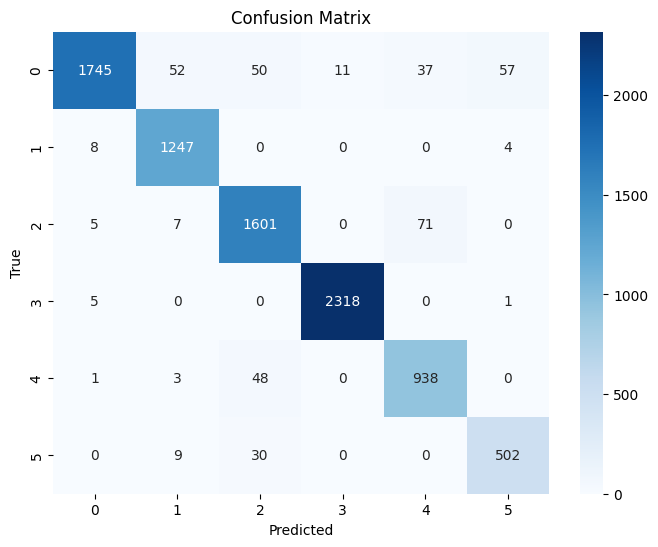

              precision    recall  f1-score   support

           0      0.989     0.894     0.939      1952
           1      0.946     0.990     0.968      1259
           2      0.926     0.951     0.938      1684
           3      0.995     0.997     0.996      2324
           4      0.897     0.947     0.921       990
           5      0.890     0.928     0.909       541

    accuracy                          0.954      8750
   macro avg      0.941     0.951     0.945      8750
weighted avg      0.956     0.954     0.954      8750



In [605]:
y_pred = model4.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))

In [606]:
import joblib


data = pd.read_csv("../real_data.csv")
scaler = joblib.load("scaler.joblib")
model = model3

In [607]:
data[LABEL_COLUMN] = data[LABEL_COLUMN].map(uc_map)
data[LABEL_COLUMN] = data[LABEL_COLUMN] - 1

APP_MAP = {'0': 0, 'amf': 1, 'gmm': 2, 'udm': 3, 'smf': 4, 'upf': 5}
LOG_MAP = {'0': 0, 'registration': 1, 'number_of_sessions_or_ues': 2,
           'nothing': 3, 'remove': 4, 'error': 5 }

data["application"] = data["application"].map(APP_MAP)
data["log_type"] = data["log_type"].map(LOG_MAP)

In [608]:
X = data[selected_features].values
y = data[LABEL_COLUMN].values
X_scaled = scaler.transform(X)

In [609]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_real_seq, y_real_seq = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

In [610]:
y_pred_probs = model.predict(X_real_seq)
y_pred = y_pred_probs.argmax(axis=1)

211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [611]:
print(classification_report(y_real_seq, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.479     1.000     0.647      3115
           1      0.000     0.000     0.000       883
           2      0.000     0.000     0.000      1291
           3      0.000     0.000     0.000      1089
           4      0.000     0.000     0.000        81
           5      0.000     0.000     0.000       266

    accuracy                          0.463      6725
   macro avg      0.080     0.167     0.108      6725
weighted avg      0.222     0.463     0.300      6725



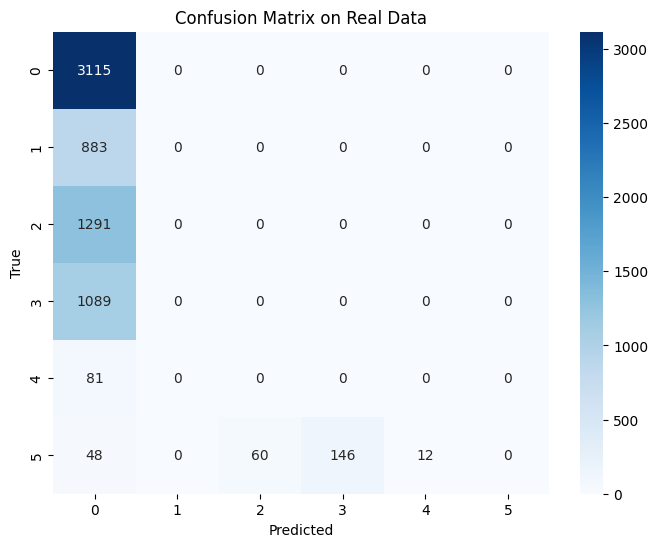

In [612]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_real_seq, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Real Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [613]:
# Uložíme model
model.save("lstm_model_batchnorm.h5")

In [614]:
from tensorflow.keras.models import load_model

model_batch = load_model("lstm_model_batchnorm.h5")

for layer in model_batch.layers[:-3]:  # zmraz všetky okrem posledných 3
    layer.trainable = False


In [615]:
real_data = pd.read_csv("../real_data.csv")

APP_MAP = {'0': 0, 'amf': 1, 'gmm': 2, 'udm': 3, 'smf': 4, 'upf': 5}
LOG_MAP = {'0': 0, 'registration': 1, 'number_of_sessions_or_ues': 2,
           'nothing': 3, 'remove': 4, 'error': 5 }

real_data['application'] = real_data['application'].map(APP_MAP)
real_data['log_type'] = real_data['log_type'].map(LOG_MAP)
real_data['current_uc'] = real_data['current_uc'].map(uc_map)
real_data[LABEL_COLUMN] = real_data[LABEL_COLUMN] - 1
real_data['timestamp'] = pd.to_datetime(real_data['timestamp'])


In [616]:
X_real = real_data[selected_features].values
y_real = real_data[LABEL_COLUMN].values

In [617]:
from joblib import load
scaler = load("scaler.joblib")
X_real_scaled = scaler.transform(X_real)

In [618]:
X_real_seq, y_real_seq = create_sequences(X_real_scaled, y_real, SEQUENCE_LENGTH)


In [619]:
# Split na malý fine-tune tréning + validáciu
X_ft, X_val, y_ft, y_val = train_test_split(
    X_real_seq, y_real_seq, test_size=0.8, stratify=y_real_seq, random_state=SEED
)

y_ft = y_ft - 1
y_val = y_val - 1

y_ft_cat = to_categorical(y_ft, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [620]:
from tensorflow.keras.optimizers import Adam

model_batch.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model_batch.fit(
    X_ft, y_ft_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,  # málo epoch
    batch_size=128,
    verbose=1,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.1445 - loss: 4.2755 - val_accuracy: 0.1336 - val_loss: 3.6165
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.1652 - loss: 3.8432 - val_accuracy: 0.1342 - val_loss: 3.3393
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.1731 - loss: 3.6417 - val_accuracy: 0.1344 - val_loss: 3.0976
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.1635 - loss: 3.5465 - val_accuracy: 0.1372 - val_loss: 2.8903
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.2069 - loss: 3.1593 - val_accuracy: 0.1632 - val_loss: 2.7199
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.2249 - loss: 3.1087 - val_accuracy: 0.1439 - val_loss: 2.5813
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.2314 - loss: 3.0414 - val_accuracy: 0.1916 - val_loss: 2.4678
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.2700 - loss: 2.7395 - val_accuracy: 0.

211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      3115
           1       0.00      0.00      0.00       883
           2       0.00      0.00      0.00      1291
           3       0.00      0.00      0.00      1089
           4       0.00      0.00      0.00        81
           5       0.00      0.00      0.00       266

    accuracy                           0.46      6725
   macro avg       0.08      0.17      0.11      6725
weighted avg       0.22      0.46      0.30      6725



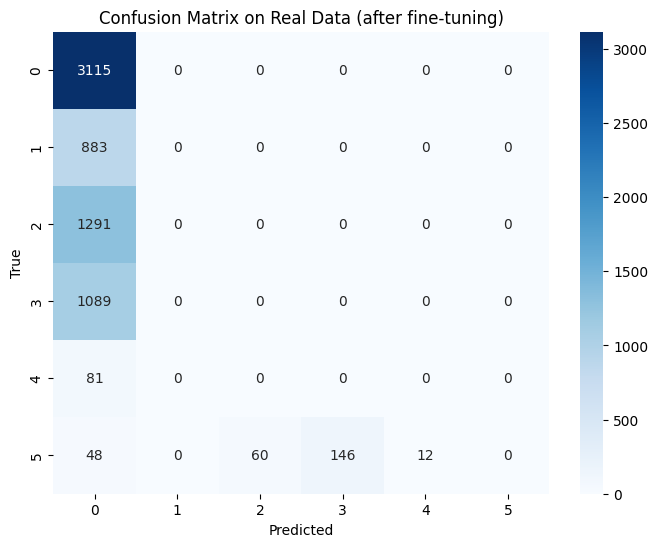

In [621]:
y_real_pred_probs = model.predict(X_real_seq)
y_real_pred = np.argmax(y_real_pred_probs, axis=1)
# Report
print(classification_report(y_real_seq, y_real_pred))

# Confusion Matrix
cm = confusion_matrix(y_real_seq, y_real_pred)

# Vizualizácia
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Real Data (after fine-tuning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

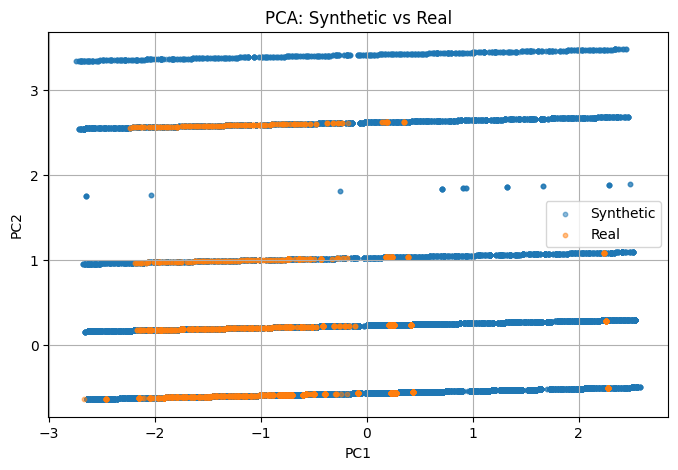

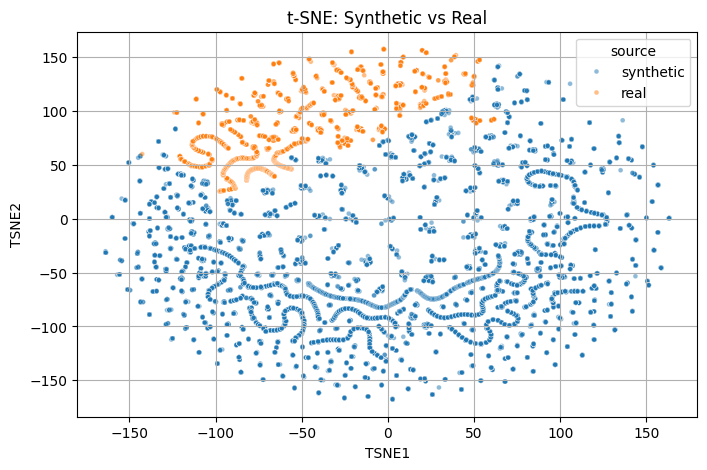


📊 KL-divergencia medzi rozloženiami syntetických a reálnych metrík:
                                                   KL Divergence
application                                             9.739031
fivegs_smffunction_sm_pdusessioncreationreq_value       5.306545
fivegs_smffunction_sm_qos_flow_nbr_value                5.009630
fivegs_pcffunction_pa_policysmassosucc_value            0.890594
fivegs_smffunction_sm_n4sessionreportsucc_value         0.350064
fivegs_upffunction_sm_n4sessionreport_value             0.330633
fivegs_pcffunction_pa_sessionnbr_value                  0.004306


In [622]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.special import rel_entr

synthetic = pd.read_csv("../synthetic_data.csv")
real = pd.read_csv("../real_data.csv")

synthetic['application'] = synthetic['application'].map(APP_MAP)
synthetic['log_type'] = synthetic['log_type'].map(LOG_MAP)
synthetic['current_uc'] = synthetic['current_uc'].map(uc_map)
synthetic[LABEL_COLUMN] = synthetic[LABEL_COLUMN] - 1

# replace NaN values with mode
synthetic = synthetic.fillna(synthetic.mode().iloc[0])
real = real.fillna(real.mode().iloc[0])

real['application'] = real['application'].map(APP_MAP)
real['log_type'] = real['log_type'].map(LOG_MAP)
real['current_uc'] = real['current_uc'].map(uc_map)
real[LABEL_COLUMN] = real[LABEL_COLUMN] - 1

# === 3. Normalizuj spolu
scaler_X = StandardScaler()
combined = pd.concat([synthetic[selected_features], real[selected_features]])
scaler_X.fit(combined)

synthetic_scaled = scaler_X.transform(synthetic[selected_features])
real_scaled = scaler_X.transform(real[selected_features])

# === 4. PCA vizualizácia
pca = PCA(n_components=2)
pca_synthetic = pca.fit_transform(synthetic_scaled)
pca_real = pca.transform(real_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(pca_synthetic[:, 0], pca_synthetic[:, 1], alpha=0.5, label='Synthetic', s=10)
plt.scatter(pca_real[:, 0], pca_real[:, 1], alpha=0.5, label='Real', s=10)
plt.title("PCA: Synthetic vs Real")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

# === 5. t-SNE vizualizácia
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(np.concatenate([synthetic_scaled, real_scaled]))
labels = ['synthetic'] * len(synthetic_scaled) + ['real'] * len(real_scaled)

tsne_df = pd.DataFrame(tsne_result, columns=["TSNE1", "TSNE2"])
tsne_df["source"] = labels

plt.figure(figsize=(8, 5))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="source", alpha=0.5, s=12)
plt.title("t-SNE: Synthetic vs Real")
plt.grid(True)
plt.show()

# === 6. KL-divergencia (jednotlivo pre každú metriku)
kl_results = {}

for f in selected_features:
    syn_vals = synthetic[f].values
    real_vals = real[f].values

    bins = np.linspace(
        min(syn_vals.min(), real_vals.min()), 
        max(syn_vals.max(), real_vals.max()), 
        100
    )

    hist_syn, _ = np.histogram(syn_vals, bins=bins, density=True)
    hist_real, _ = np.histogram(real_vals, bins=bins, density=True)

    # Laplace smoothing (aby sa vyhli nule)
    hist_syn += 1e-9
    hist_real += 1e-9

    kl_div = np.sum(rel_entr(hist_syn, hist_real))
    kl_results[f] = kl_div

# === 7. Výpis výsledkov
kl_df = pd.DataFrame.from_dict(kl_results, orient='index', columns=['KL Divergence']).sort_values(by='KL Divergence', ascending=False)
print("\n📊 KL-divergencia medzi rozloženiami syntetických a reálnych metrík:")
print(kl_df)


In [623]:
# Budeme používať iba metriky, ktoré majú KL-divergenciu < 5
selected_features = kl_df[kl_df['KL Divergence'] < 5].index.tolist()
print(f"✅ Selected features based on KL divergence: {selected_features}")

✅ Selected features based on KL divergence: ['fivegs_pcffunction_pa_policysmassosucc_value', 'fivegs_smffunction_sm_n4sessionreportsucc_value', 'fivegs_upffunction_sm_n4sessionreport_value', 'fivegs_pcffunction_pa_sessionnbr_value']
